# Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import polars as pl
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from scifi.utils import get_reviewer_mapping
from scifi.visualize import (
    create_voting_text,
    rating_to_color,
)

In [ ]:
# Read the processed book club data
bookclub_processed_df = pl.read_csv("data/processed_data.csv")

# Get a list of book club members
bookclub_members_list = list(get_reviewer_mapping().values())

print(bookclub_processed_df)

In [3]:
# Calculate average ratings for each member and create ordered list
member_averages = []
for member in bookclub_members_list:
    avg_rating = (
        bookclub_processed_df.select(member)
        .filter(pl.col(member) != 0)
        .select(pl.col(member).mean())
        .item()
    )
    member_averages.append((member, avg_rating))

# Sort by average rating (lowest to highest)
member_averages.sort(key=lambda x: x[1])
ordered_members = [member for member, _ in member_averages]

In [ ]:
selected_book = "Concept M"

book_plot_df = bookclub_processed_df.filter(pl.col("title") == selected_book)
categories = list(get_reviewer_mapping().values())
values = [book_plot_df.select(member).to_series().item() for member in categories]

# Calculate average rating (excluding None/null values)
valid_values = [v for v in values if v is not None and v != 0]
avg_rating = float(np.mean(valid_values)) if valid_values else 0.0

fill_color = rating_to_color(avg_rating, alpha=0.3)  # Transparent fill
line_color = rating_to_color(avg_rating, alpha=1.0)  # Opaque line

fig = go.Figure()
fig.add_trace(
    go.Scatterpolar(
        r=values,
        theta=categories,
        fill="toself",
        name=selected_book,
        fillcolor=fill_color,
        line={"color": line_color},
    ),
)

fig.update_layout(
    polar={"radialaxis": {"visible": True, "range": [0, 5]}},
    showlegend=False,
    title=f"Ratings for {selected_book} (avg: {avg_rating:.2f})",
)

fig.show()

In [5]:
# Create a long-form dataframe to plot ratings for each person
long_df = bookclub_processed_df.select(["title", *bookclub_members_list]).unpivot(
    index="title",
    on=bookclub_members_list,
    variable_name="Member",
    value_name="Rating",
)

# Bar plot of ratings per member
fig = px.histogram(
    long_df,
    x="Rating",
    color="Member",
    barmode="group",
    title="Distribution of Book Club Ratings",
    labels={"Rating": "Rating", "Member": "Book Club Member"},
)

fig.show()

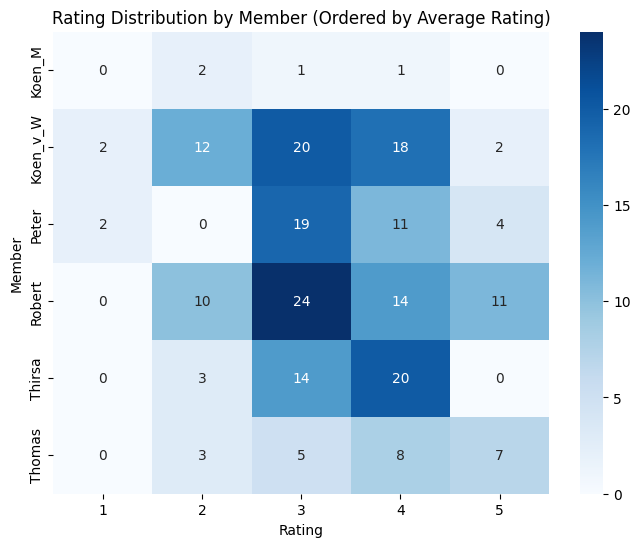

In [6]:
# Create rating distribution data for heatmap
rating_matrix = []
for member in ordered_members:
    member_ratings = bookclub_processed_df.select(member).filter(pl.col(member) != 0)

    # Count ratings for each category (1-5)
    rating_counts = []
    for rating in [1, 2, 3, 4, 5]:
        count = len(member_ratings.filter(pl.col(member) == rating))
        rating_counts.append(count)

    rating_matrix.append(rating_counts)

# Create heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    rating_matrix,
    xticklabels=[1, 2, 3, 4, 5],
    yticklabels=ordered_members,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=ax,
)

ax.set_title("Rating Distribution by Member (Ordered by Average Rating)")
ax.set_xlabel("Rating")
ax.set_ylabel("Member")

plt.show()

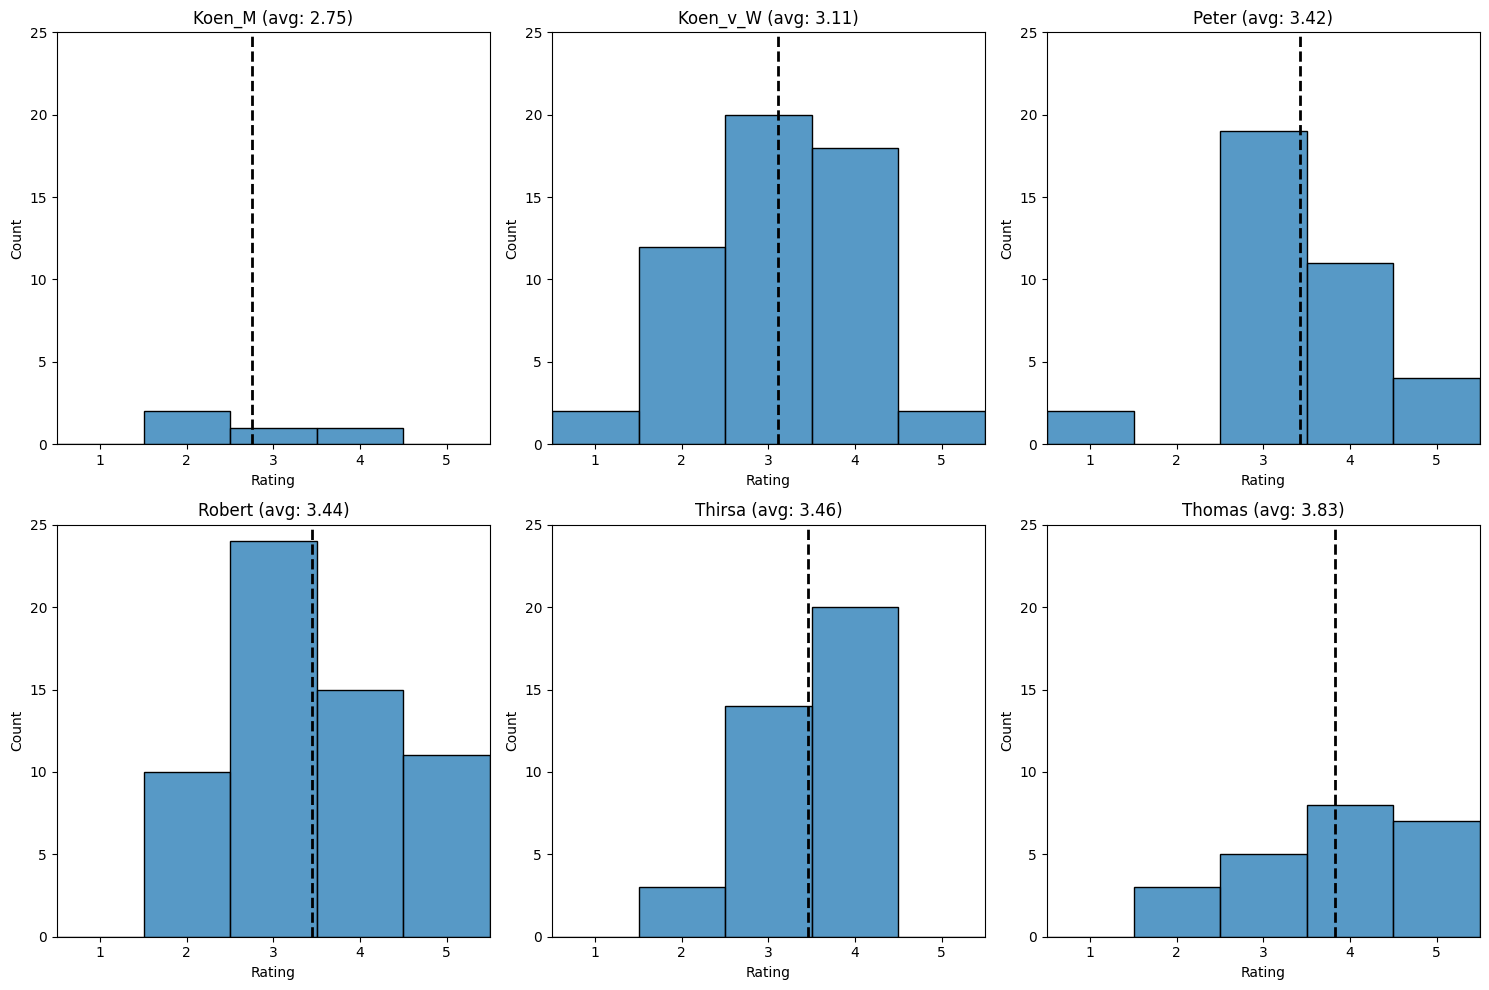

In [7]:
# Create subplot grid (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Define consistent bins for all plots
bins = np.arange(0.5, 6, 1)  # This creates bins [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]

for i, (member, avg_rating) in enumerate(member_averages):
    # Extract member's ratings
    member_ratings = bookclub_processed_df.select(member).filter(pl.col(member) != 0)

    # Create histogram for this member
    sns.histplot(
        data=member_ratings,
        x=member,
        bins=bins,  # Use consistent bins
        stat="count",
        ax=axes[i],
    )

    # Set x-axis to show only integers 1-5
    axes[i].set_xticks([1, 2, 3, 4, 5])
    axes[i].set_xlim(0.5, 5.5)

    # Set y-axis to consistent maximum
    axes[i].set_ylim(0, 25)

    # Add average line
    axes[i].axvline(avg_rating, color="black", linestyle="--", linewidth=2)

    # Set title and labels
    axes[i].set_title(f"{member} (avg: {avg_rating:.2f})")
    axes[i].set_xlabel("Rating")
    axes[i].set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()

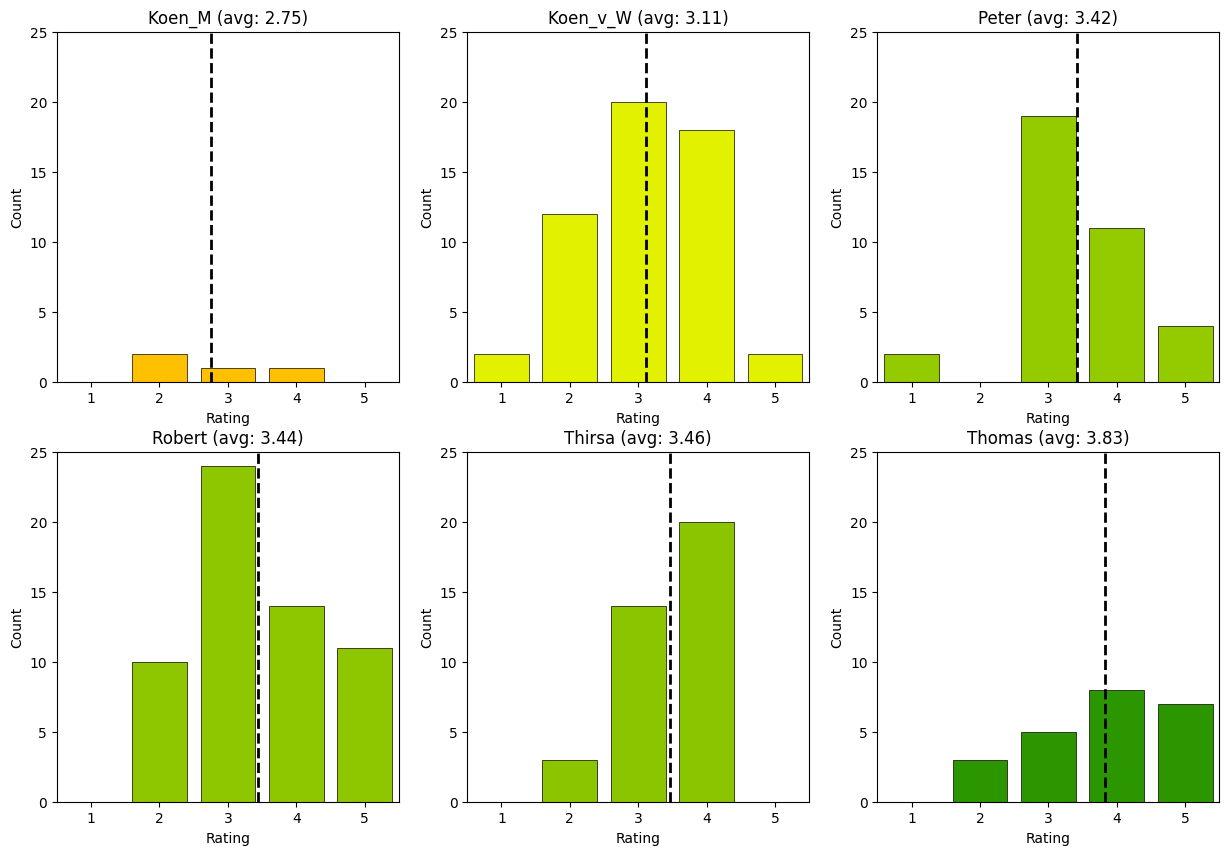

In [8]:
# Create color map from red to green
cmap = LinearSegmentedColormap.from_list("red_to_green", ["red", "yellow", "green"])

# Create subplot grid (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (member, avg_rating) in enumerate(member_averages):
    # Map average rating to color (2=red, 4=green)
    color_value = (avg_rating - 2) / 2  # Normalize 2-4 range to 0-1
    color_value = np.clip(color_value, 0, 1)  # Clamp to 0-1 range
    member_color = cmap(color_value)

    # Extract member's ratings
    member_ratings = bookclub_processed_df.select(member).filter(pl.col(member) != 0)

    # Calculate histogram counts for each rating
    rating_counts = []
    for rating in [1, 2, 3, 4, 5]:
        count = len(member_ratings.filter(pl.col(member) == rating))
        rating_counts.append(count)

    # Create bar plot with member's color
    bars = axes[i].bar(
        [1, 2, 3, 4, 5],
        rating_counts,
        color=member_color,
        width=0.8,
        edgecolor="black",
        linewidth=0.5,
    )

    # Set x-axis and y-axis
    axes[i].set_xticks([1, 2, 3, 4, 5])
    axes[i].set_xlim(0.5, 5.5)
    axes[i].set_ylim(0, 25)

    # Add average line
    axes[i].axvline(avg_rating, color="black", linestyle="--", linewidth=2)

    # Set title and labels
    axes[i].set_title(f"{member} (avg: {avg_rating:.2f})")
    axes[i].set_xlabel("Rating")
    axes[i].set_ylabel("Count")

plt.show()

In [9]:
plot_df = bookclub_processed_df.with_columns(
    [pl.col("original_publication_year").cast(pl.Int32).alias("year")],
)
df_plot = plot_df.sort("year")

# Add the voting members column using map_rows
df_with_voting = df_plot.with_columns(
    pl.struct(bookclub_members_list)
    .map_elements(lambda row: create_voting_text(bookclub_members_list, row), return_dtype=pl.Utf8)
    .alias("voting_members"),
)

fig = px.line(
    df_with_voting,
    x="year",
    y="average_bookclub_rating",
    title="Our Rating per Publication Year",
    labels={"year": "Publication Year", "average_bookclub_rating": "Average Rating"},
    markers=True,
)

# Update hover template for bookclub rating
fig.update_traces(
    hovertemplate="<b>%{customdata[0]}</b><br>"
    "Author: %{customdata[1]}<br>"
    "Year: %{x}<br>"
    "Bookclub Rating: %{y:.2f}<br>"
    "%{customdata[2]}<extra></extra>",
    customdata=df_with_voting.select(["title", "author", "voting_members"]).to_numpy(),
)

# Add Goodreads rating as a dashed red line
fig.add_trace(
    go.Scatter(
        x=df_with_voting["year"],
        y=df_with_voting["average_goodreads_rating"],
        mode="lines+markers",
        name="Goodreads Rating",
        line={"color": "red", "dash": "dash"},
        customdata=df_with_voting.select(["title", "author", "voting_members"]).to_numpy(),
        hovertemplate="<b>%{customdata[0]}</b><br>"
        "Author: %{customdata[1]}<br>"
        "Year: %{x}<br>"
        "Goodreads Rating: %{y:.2f}<br>"
        "%{customdata[2]}<extra></extra>",
    ),
)

# Update y-axis label to be more generic
fig.update_layout(yaxis_title="Average Rating")

fig.show()

In [10]:
# Sort the dataframe by date
plot_df = bookclub_processed_df.sort("date")

# Add the voting members column using map_rows (same as first figure)
df_with_voting = plot_df.with_columns(
    pl.struct(bookclub_members_list)
    .map_elements(lambda row: create_voting_text(bookclub_members_list, row), return_dtype=pl.Utf8)
    .alias("voting_members"),
)

# Create a Plotly figure
fig = go.Figure()

# Add a line trace for the rating over time, with enhanced hover information
fig.add_trace(
    go.Scatter(
        x=df_with_voting["date"],
        y=df_with_voting["average_bookclub_rating"],
        mode="lines+markers",
        name="Bookclub Rating",
        customdata=df_with_voting.select(["title", "author", "voting_members"]).to_numpy(),
        hovertemplate="<b>%{customdata[0]}</b><br>"
        "Author: %{customdata[1]}<br>"
        "Date: %{x|%Y-%m-%d}<br>"
        "Bookclub Rating: %{y:.2f}<br>"
        "%{customdata[2]}<extra></extra>",
    ),
)

# Add a line trace for the average Goodreads rating over time
fig.add_trace(
    go.Scatter(
        x=df_with_voting["date"],
        y=df_with_voting["average_goodreads_rating"],
        mode="lines+markers",
        name="Goodreads Rating",
        customdata=df_with_voting.select(["title", "author", "voting_members"]).to_numpy(),
        hovertemplate="<b>%{customdata[0]}</b><br>"
        "Author: %{customdata[1]}<br>"
        "Date: %{x|%Y-%m-%d}<br>"
        "Goodreads Rating: %{y:.2f}<br>"
        "%{customdata[2]}<extra></extra>",
        line={"dash": "dash"},  # Optionally make the Goodreads rating line dashed
    ),
)

# Set the title and labels for axes
fig.update_layout(
    title="Rating Over Time",
    xaxis_title="Date",
    yaxis_title="Rating",
    template="plotly_white",
)

# Show the interactive plot
fig.show()